In [1]:
%matplotlib inline

# Compute Eigenvalues using MAPDL or SciPy {#ref_mapdl_math_mapdl_vs_scipy}

This example shows:

-   How to extract the stiffness and mass matrices from a MAPDL model.
-   How to use the `Math` module of PyMapdl to compute the first
    eigenvalues.
-   How to can get these matrices in the SciPy world, to get the same
    solutions using Python resources.
-   How MAPDL is really faster than SciPy :)


In [2]:
import math

First load python packages we need for this example


In [3]:
import time

import matplotlib.pylab as plt
import numpy as np
import scipy
from scipy.sparse.linalg import eigsh

from ansys.mapdl.core import examples
import ansys.math.core.math as amath

# Start Ansys Math
mm = amath.Math()

APDLMath EigenSolve First load the input file using MAPDL.


In [4]:
print(mm._mapdl.input(examples.examples.wing_model))


 /INPUT FILE= D:\repos\pyansys\ansys-math\.venv\Lib\site-packages\ansys\mapdl\core\examples\wing.dat  LINE=       0

 *** MAPDL - ENGINEERING ANALYSIS SYSTEM  RELEASE 2022 R2          22.2     ***
 Ansys Mechanical Enterprise                       
 00000000  VERSION=WINDOWS x64   15:31:03  DEC 19, 2022 CP=      0.766

                                                                               



          ***** MAPDL ANALYSIS DEFINITION (PREP7) *****

 *** WARNING ***                         CP =       0.766   TIME= 15:31:03
 Deactivation of element shape checking is not recommended.              

 *** WARNING ***                         CP =       0.812   TIME= 15:31:03
 The mesh of area 1 contains PLANE42 triangles, which are much too stiff 
 in bending.  Use quadratic (6- or 8-node) elements if possible.         

 *** WARNING ***                         CP =       0.828   TIME= 15:31:03
 CLEAR, SELECT, and MESH boundary condition commands are not possible    
 after MODMSH. 

Plot and mesh using the `eplot` method.


d:\repos\pyansys\ansys-math\.venv\lib\site-packages\pyvista\jupyter\notebook.py:60: UserWarning: Failed to use notebook backend: 

Please install `ipyvtklink` to use this feature: https://github.com/Kitware/ipyvtklink

Falling back to a static output.
  warnings.warn(


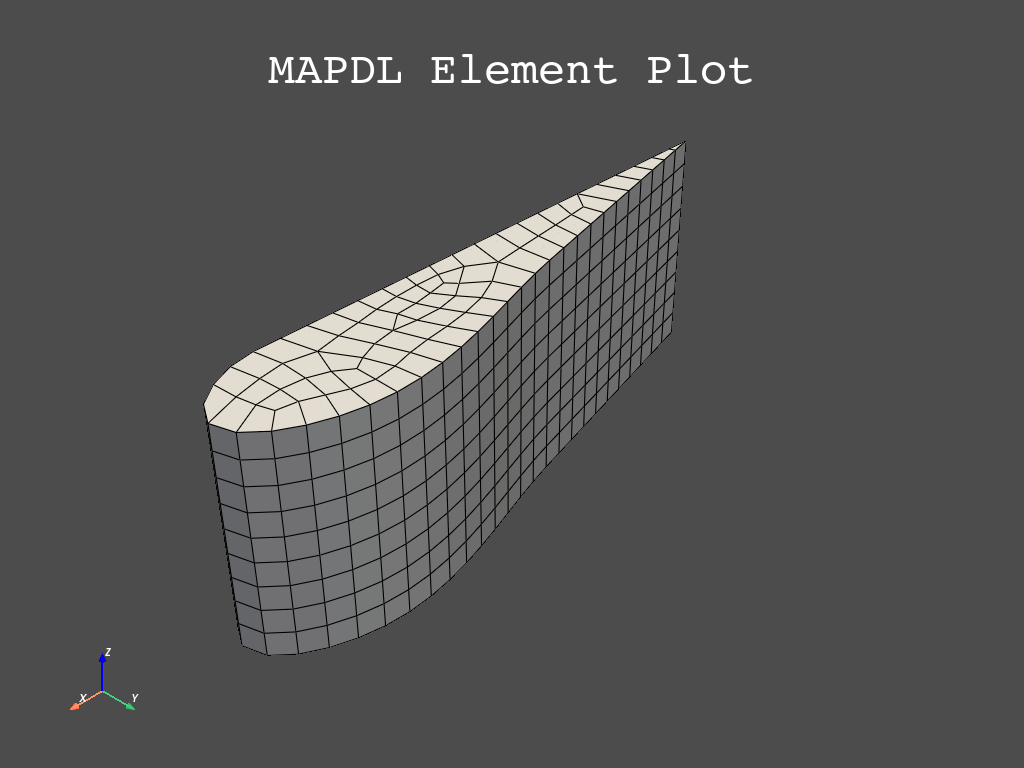

In [5]:
mm._mapdl.eplot()

Next, setup a modal Analysis and request the $K$ and
math:[M]{.title-ref} matrices to be formed. MAPDL stores these matrices
in a `.FULL` file.


In [6]:
print(mm._mapdl.slashsolu())
print(mm._mapdl.antype(antype="MODAL"))
print(mm._mapdl.modopt(method="LANB", nmode="10", freqb="1."))
print(mm._mapdl.wrfull(ldstep="1"))

# store the output of the solve command
output = mm._mapdl.solve()

*****  MAPDL SOLUTION ROUTINE  *****
PERFORM A MODAL ANALYSIS
  THIS WILL BE A NEW ANALYSIS
USE SYM. BLOCK LANCZOS MODE EXTRACTION METHOD
  EXTRACT    10 MODES
  SHIFT POINT FOR EIGENVALUE CALCULATION=  1.0000    
  NORMALIZE THE MODE SHAPES TO THE MASS MATRIX
STOP SOLUTION AFTER FULL FILE HAS BEEN WRITTEN
   LOADSTEP =    1 SUBSTEP =    1 EQ. ITER =    1


Read the sparse matrices using PyMapdl.


In [7]:
mm._mapdl.finish()
mm.free()
k = mm.stiff(fname="file.full")
M = mm.mass(fname="file.full")

Solve the eigenproblem using PyMapdl with APDLMath.


In [8]:
nev = 10
A = mm.mat(k.nrow, nev)

t1 = time.time()
ev = mm.eigs(nev, k, M, phi=A, fmin=1.0)
t2 = time.time()
mapdl_elapsed_time = t2 - t1
print("\nElapsed time to solve this problem : ", mapdl_elapsed_time)


Elapsed time to solve this problem :  1.3008067607879639


Print eigenfrequencies and accuracy.

Accuracy : $\frac{||(K-\lambda.M).\phi||_2}{||K.\phi||_2}$


In [9]:
mapdl_acc = np.empty(nev)

for i in range(nev):
    f = ev[i]  # Eigenfrequency (Hz)
    omega = 2 * np.pi * f  # omega = 2.pi.Frequency
    lam = omega**2  # lambda = omega^2

    phi = A[i]  # i-th eigenshape
    kphi = k.dot(phi)  # K.Phi
    mphi = M.dot(phi)  # M.Phi

    kphi_nrm = kphi.norm()  # Normalization scalar value

    mphi *= lam  # (K-\lambda.M).Phi
    kphi -= mphi

    mapdl_acc[i] = kphi.norm() / kphi_nrm  # compute the residual
    print(f"[{i}] : Freq = {f:8.2f} Hz\t Residual = {mapdl_acc[i]:.5}")

[0] : Freq =   352.39 Hz	 Residual = 1.9659e-08
[1] : Freq =   385.21 Hz	 Residual = 8.5093e-09
[2] : Freq =   656.77 Hz	 Residual = 1.1362e-08
[3] : Freq =   764.72 Hz	 Residual = 8.1529e-09
[4] : Freq =   825.44 Hz	 Residual = 8.805e-09
[5] : Freq =  1039.25 Hz	 Residual = 1.1895e-08
[6] : Freq =  1143.61 Hz	 Residual = 1.1819e-08
[7] : Freq =  1258.00 Hz	 Residual = 1.8103e-08
[8] : Freq =  1334.22 Hz	 Residual = 1.1652e-08
[9] : Freq =  1352.01 Hz	 Residual = 1.7036e-08


# Use SciPy to Solve the same Eigenproblem

First get MAPDL sparse matrices into the Python memory as SciPy
matrices.


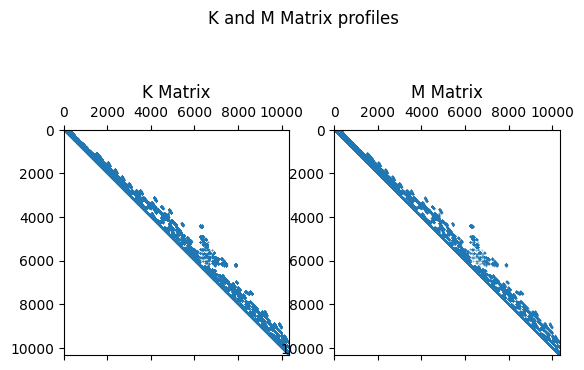

In [10]:
pk = k.asarray()
pm = M.asarray()

# get_ipython().run_line_magic('matplotlib', 'inline')

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle("K and M Matrix profiles")
ax1.spy(pk, markersize=0.01)
ax1.set_title("K Matrix")
ax2.spy(pm, markersize=0.01)
ax2.set_title("M Matrix")
plt.show(block=True)

Make the sparse matrices for SciPy unsymmetric as symmetric matrices in
SciPy are memory inefficient.

$K = K + K^T - diag(K)$


In [11]:
pkd = scipy.sparse.diags(pk.diagonal())
pK = pk + pk.transpose() - pkd
pmd = scipy.sparse.diags(pm.diagonal())
pm = pm + pm.transpose() - pmd

Plot Matrices


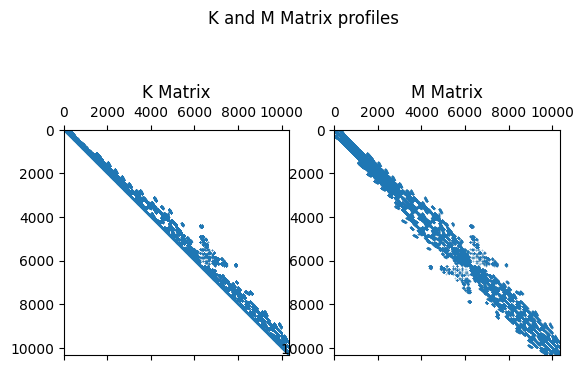

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle("K and M Matrix profiles")
ax1.spy(pk, markersize=0.01)
ax1.set_title("K Matrix")
ax2.spy(pm, markersize=0.01)
ax2.set_title("M Matrix")
plt.show(block=True)

Solve the eigenproblem


In [13]:
t3 = time.time()
vals, vecs = eigsh(A=pK, M=pm, k=10, sigma=1, which="LA")
t4 = time.time()
scipy_elapsed_time = t4 - t3
print("\nElapsed time to solve this problem : ", scipy_elapsed_time)


Elapsed time to solve this problem :  30.480971574783325


Convert Lambda values to Frequency values:
$freq = \frac{\sqrt(\lambda)}{2.\pi}$


In [14]:
freqs = np.sqrt(vals) / (2 * math.pi)

Compute the residual error for SciPy.

$Err=\frac{||(K-\lambda.M).\phi||_2}{||K.\phi||_2}$


In [15]:
scipy_acc = np.zeros(nev)

for i in range(nev):
    lam = vals[i]  # i-th eigenvalue
    phi = vecs.T[i]  # i-th eigenshape

    kphi = pk * phi.T  # K.Phi
    mphi = pm * phi.T  # M.Phi

    kphi_nrm = np.linalg.norm(kphi, 2)  # Normalization scalar value

    mphi *= lam  # (K-\lambda.M).Phi
    kphi -= mphi

    scipy_acc[i] = 1 - np.linalg.norm(kphi, 2) / kphi_nrm  # compute the residual
    print(f"[{i}] : Freq = {freqs[i]:8.2f} Hz\t Residual = {scipy_acc[i]:.5}")

[0] : Freq =   352.39 Hz	 Residual = 8.0075e-05
[1] : Freq =   385.21 Hz	 Residual = 0.00010351
[2] : Freq =   656.77 Hz	 Residual = 0.00024252
[3] : Freq =   764.72 Hz	 Residual = 0.00016258
[4] : Freq =   825.43 Hz	 Residual = 0.00038959
[5] : Freq =  1039.25 Hz	 Residual = 0.00057544
[6] : Freq =  1143.61 Hz	 Residual = 0.0025878
[7] : Freq =  1257.97 Hz	 Residual = 0.00033879
[8] : Freq =  1334.20 Hz	 Residual = 0.00046617
[9] : Freq =  1352.01 Hz	 Residual = 0.001126


MAPDL is more accurate than SciPy.


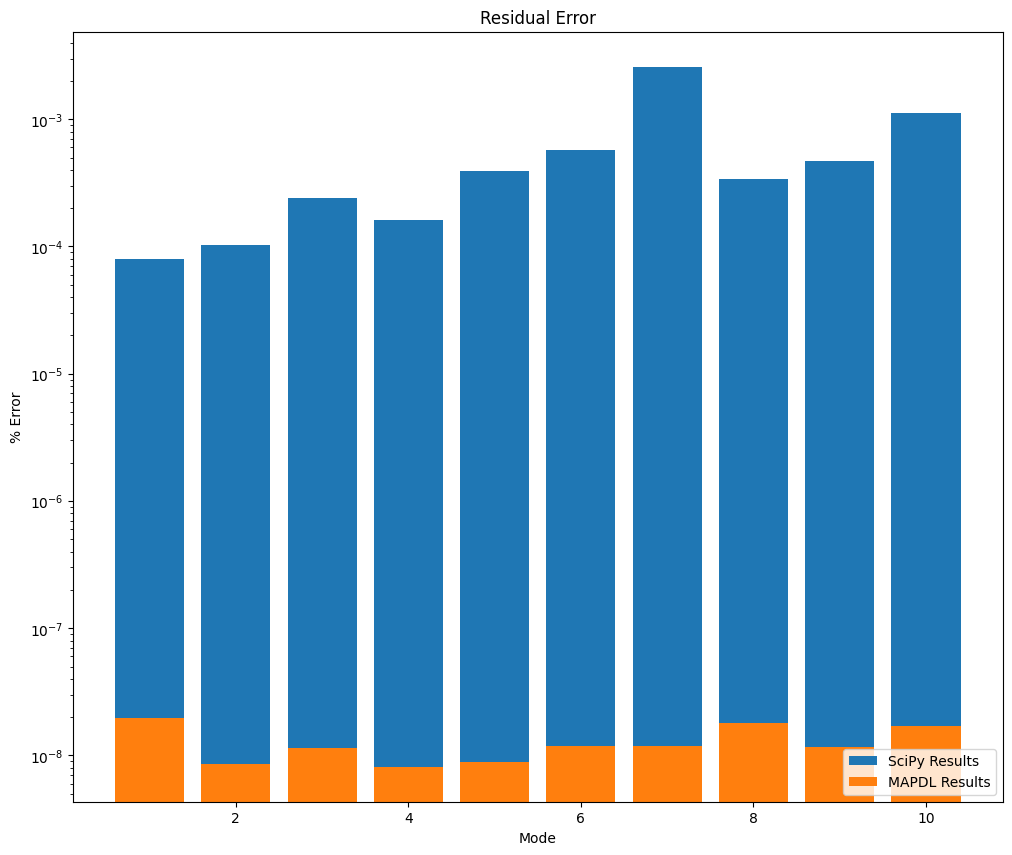

In [16]:
fig = plt.figure(figsize=(12, 10))
ax = plt.axes()
x = np.linspace(1, 10, 10)
plt.title("Residual Error")
plt.yscale("log")
plt.xlabel("Mode")
plt.ylabel("% Error")
ax.bar(x, scipy_acc, label="SciPy Results")
ax.bar(x, mapdl_acc, label="MAPDL Results")
plt.legend(loc="lower right")
plt.show()

MAPDL is faster than SciPy.


In [17]:
ratio = scipy_elapsed_time / mapdl_elapsed_time
print(f"Mapdl is {ratio:.3} times faster")

Mapdl is 23.4 times faster


stop mapdl


In [18]:
mm._mapdl.exit()